Nessa etapa vamos receber a imagem e o grupo_produto e retornar a classificação do produto.

-> recebe a img e o grupo_produto\
-> transforma a img em embedding\
-> pega a loc da img em cada subespaço\
-> classifica a img pegando em cada subespaco o centroide mais proximo

In [14]:
# output = {
#     classificao: {atributo: valor},
#     img_embedding: [array],
#     loc_nos_subespacos: {nome do subespaco: array}
# }

In [15]:
# carregando imagem
from PIL import Image
import requests
from io import BytesIO
import pandas as pd

In [20]:
#url = 'https://animaleproductsimages.s3.us-east-1.amazonaws.com/foto_cortada/vestido_slip-dress-de-georgette-com-detalhe-de-pregas-estampado_est-onca-moderna-color_07-20-6541-09621.jpg'
path = 'C:/Users/Nicole.Souza.HOMLABNOT002581/Downloads/top-blusa_camiseta-tricot-com-textura_off-white_52-06-0636-0024.jpg'
path = 'C:/Users/Nicole.Souza.HOMLABNOT002581/Downloads/calca_calca-jeans-boot-basic-high-fenda_jeans-medio_25-34-1799-0105.jpg'

# response = requests.get(url)

# INPUTS
# img = Image.open(BytesIO(response.content))
img = Image.open(path)
grupo_produto = 'calca'

In [4]:
from utils import get_atributos_dict

dict_atributos = get_atributos_dict('./datasets')
dict_atributos

{'blusa': ['blusa_comprimento_blusa',
  'blusa_comprimento_manga',
  'blusa_decote',
  'cor',
  'estampa',
  'estampado'],
 'calca': ['calca_comprimento_calca',
  'calca_modelagem_calca',
  'cor',
  'estampa',
  'estampado'],
 'vestido': ['cor',
  'estampa',
  'estampado',
  'vestido_comprimento_manga',
  'vestido_comprimento_saia',
  'vestido_contem_alca',
  'vestido_contem_manga',
  'vestido_decote',
  'vestido_decote_ou_gola',
  'vestido_modelagem_saia'],
 'saia': ['cor',
  'estampa',
  'estampado',
  'saia_comprimento_saia',
  'saia_modelagem_saia'],
 'short': ['cor',
  'estampa',
  'estampado',
  'short_comprimento_short',
  'short_modelagem_short']}

In [5]:

{
    'blusa': 
    ['blusa_comprimento_blusa',
        'blusa_comprimento_manga',
        'blusa_decote',
        'cor',
        'estampa',
        'estampado'],
       'calca': ['calca_comprimento_calca',
        'calca_modelagem_calca',
        'cor',
        'estampa',
        'estampado'],
       'vestido': ['cor',
        'estampa',
        'estampado',
        'vestido_comprimento_manga',
        'vestido_comprimento_saia',
        'vestido_contem_alca',
        'vestido_contem_manga',
        'vestido_decote',
        'vestido_modelagem_saia'],
       'saia': ['cor',
        'estampa',
        'estampado',
        'saia_comprimento_saia',
        'saia_modelagem_saia'],
       'short': ['cor',
        'estampa',
        'estampado',
        'short_comprimento_short',
        'short_modelagem_short']
}

{'blusa': ['blusa_comprimento_blusa',
  'blusa_comprimento_manga',
  'blusa_decote',
  'cor',
  'estampa',
  'estampado'],
 'calca': ['calca_comprimento_calca',
  'calca_modelagem_calca',
  'cor',
  'estampa',
  'estampado'],
 'vestido': ['cor',
  'estampa',
  'estampado',
  'vestido_comprimento_manga',
  'vestido_comprimento_saia',
  'vestido_contem_alca',
  'vestido_contem_manga',
  'vestido_decote',
  'vestido_modelagem_saia'],
 'saia': ['cor',
  'estampa',
  'estampado',
  'saia_comprimento_saia',
  'saia_modelagem_saia'],
 'short': ['cor',
  'estampa',
  'estampado',
  'short_comprimento_short',
  'short_modelagem_short']}

In [6]:
import pickle
import torch

def get_img_embedding(img, embedding_model):
    """
    Recebe uma imagem e um modelo de embedding e retorna um df com colunas emb_img_{i}
    onde i é o índice do vetor de embedding
    """
    
    # Transformar imagem em embedding
    img_emb = embedding_model.encode(img)

    # Criar DataFrame com embeddings
    df_img_emb = pd.DataFrame([img_emb], columns=[f'emb_img_{i}' for i in range(len(img_emb))])
    return df_img_emb


def get_loc_nos_subespacos(img_embedding, grupo_produto, datasets_path, models_path):
    """
    Recebe um embedding de imagem, um grupo de produto, o caminho para os datasets e o caminho para os modelos
    e retorna o local da imagem nos subespaços de cada atributo do grupo de produto (.transform nos modelos lda)
    """

    dict_atributos = get_atributos_dict(datasets_path)

    # Encontra os subespaços com base no grupo de produto
    atributos = dict_atributos[grupo_produto]

    loc_nos_subespacos = {}

    for atributo in atributos:
        # le os modelos usados pra gerar o subespaço de 'models_path/lda_model_{atributo}.pkl'
        lda_model = pickle.load(open(f'{models_path}/lda_model_{atributo}.pkl', 'rb'))

        # .transform(img_embedding) para encontrar a localização do ponto no subespaço
        loc_nos_subespacos[atributo] = lda_model.transform(img_embedding)

    return loc_nos_subespacos

def get_centroides_mais_proximos(loc_nos_subespacos, grupo_produto, datasets_path):
    """
    Recebe o local da imagem nos subespaços, um grupo de produto, o caminho para os datasets e o caminho para os modelos
    e retorna o centroide mais próximo da imagem
    """

    dict_atributos = get_atributos_dict(datasets_path)

    # Encontra os subespaços com base no grupo de produto
    atributos = dict_atributos[grupo_produto]

    centroide_mais_proximo = {}

    for atributo in atributos:
        # le os subespacos em 'datasets_path/df_subespace_{atributo}.parquet'
        subespaco = pd.read_parquet(f'./datasets/df_subespace_{atributo}.parquet')

        # localização da imagem no subespaço
        loc_atributo = loc_nos_subespacos[atributo]

        # colunas lda
        colunas_lda = [f'EMB_LDA_{i}' for i in range(loc_atributo.shape[1])]

        # pegando os centroides
        centroides = subespaco.loc[subespaco['is_centroid'] == True].reset_index(drop=True)
        nomes_centroides = centroides['id_produto'].values
        centroides = centroides[colunas_lda].values

        # pegando as distâncias dos centroides
        centroides = torch.tensor(centroides, dtype=torch.float32)
        loc_atributo = torch.tensor(loc_atributo, dtype=torch.float32)

        euclidean_dist = torch.cdist(loc_atributo, centroides, p=2)

        # obtendo o centroide mais próximo
        centroide_mais_proximo[atributo] = nomes_centroides[euclidean_dist.argmin()]           

    return centroide_mais_proximo

In [7]:
def get_classificacao_img(img: Image, grupo_produto: str, datasets_path: str, models_path: str,  emb_model: object) -> dict:
    """
    Retorna a classificação da imagem.
    
    Args:
        img: Imagem a ser classificada.
        grupo_produto: Grupo de produto ao qual a imagem pertence.
        datasets_path: Caminho para a pasta onde estão os datasets.
        emb_model: Modelo de embedding a ser utilizado.

    Returns:
        dict: Dicionário contendo a classificação da imagem.

        output = {
        classificao: {atributo: valor},
        img_embedding: [array],
        loc_nos_subespacos: {nome do subespaco: array}
        }
    """

    # ETAPA 1: Embedding da imagem
    img_embedding = get_img_embedding(img, emb_model)

    # ETAPA 2: Pegando a localização da imagem em cada subespaço dado o grupo de produto
    loc_nos_subespacos = get_loc_nos_subespacos(img_embedding, grupo_produto, datasets_path, models_path)

    # ETAPA 3: Classificação da imagem
    classificacao = get_centroides_mais_proximos(loc_nos_subespacos, grupo_produto, datasets_path)
    
    output = {
        'classificacao': classificacao,
        'img_embedding': img_embedding,
        'loc_nos_subespacos': loc_nos_subespacos
    }

    return output

### Testando

In [17]:
from sentence_transformers import SentenceTransformer, util

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

output = get_classificacao_img(img, grupo_produto, './datasets', './models', img_model)

C:\Users\Nicole.Souza.HOMLABNOT002581\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
from segmentation import get_cropped_image_from_pil
from transformers import pipeline

pipe = pipeline("image-segmentation", model="sayeed99/segformer_b3_clothes")

cropped_img, _ = get_cropped_image_from_pil(img, grupo_produto, pipe)

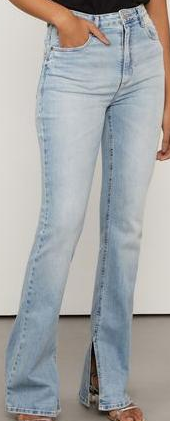

In [22]:
cropped_img

In [11]:
output['classificacao']

{'cor': 'CLUSTER_BEGE',
 'estampa': 'CLUSTER_listra',
 'estampado': 'CLUSTER_False',
 'vestido_comprimento_manga': 'CLUSTER_MANGA_CURTA',
 'vestido_comprimento_saia': 'CLUSTER_MIDI',
 'vestido_contem_alca': 'CLUSTER_True',
 'vestido_contem_manga': 'CLUSTER_False',
 'vestido_decote': 'CLUSTER_CORACAO',
 'vestido_decote_ou_gola': 'CLUSTER_CORACAO',
 'vestido_modelagem_saia': 'CLUSTER_JUSTA'}

In [42]:
output = get_classificacao_img(cropped_img, grupo_produto, './datasets', './models', img_model)['classificacao']

In [43]:
output

{'calca_comprimento_calca': 'CLUSTER_CANELA',
 'calca_modelagem_calca': 'CLUSTER_RETA',
 'cor': 'CLUSTER_AZUL',
 'estampa': 'CLUSTER_floral',
 'estampado': 'CLUSTER_False'}